# Депозиты

Перед вами - датасет одного португальского банка о результатах прозвона клиентов с предложением разместить депозит. 

Ваша задача:
* выяснить, какие факторы влияют на готовность клиента разместить депозит
* построить модель, предсказывающую для каждого клиента вероятность того, что в результате звонка он разместит депозит

Это необходимо для оптимизации маркетинговой кампании: звонить в первую очередь только тем клиентам, которые наиболее склонны к отклику. Данные находятся на первом листе файла ```bank_data.xlsx```

bank client data:
1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric) 
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:
9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. duration: last contact duration, in seconds (numeric)

other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
  17. y. has the client subscribed a term deposit? (binary: "yes","no")


In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [23]:
data = pd.read_excel('bank_data.xlsx')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [24]:
data.head(3).transpose()

,0,1,2
age,58,44,33
job,management,technician,entrepreneur
marital,married,single,married
education,tertiary,secondary,secondary
default,no,no,no
balance,2143,29,2
housing,yes,yes,yes
loan,no,no,yes
contact,unknown,unknown,unknown
day,5,5,5


In [25]:
by_y = data['y'].value_counts()
by_y

no     39922
yes     5289
Name: y, dtype: int64

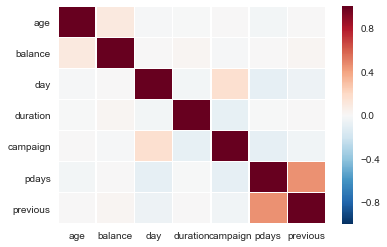

In [26]:
sns.heatmap(data.corr(), linewidths=.5);

In [27]:
y = (data['y'] == 'yes').astype(int)
x_raw = data.drop('y', axis = 1)
x = pd.get_dummies(x_raw[['age', 'job', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']], drop_first = True)
x_raw['y_val'] = y

print(x_raw)

       age            job   marital  education default  balance housing loan  \
0       58     management   married   tertiary      no     2143     yes   no   
1       44     technician    single  secondary      no       29     yes   no   
2       33   entrepreneur   married  secondary      no        2     yes  yes   
3       47    blue-collar   married    unknown      no     1506     yes   no   
4       33        unknown    single    unknown      no        1      no   no   
5       35     management   married   tertiary      no      231     yes   no   
6       28     management    single   tertiary      no      447     yes  yes   
7       42   entrepreneur  divorced   tertiary     yes        2     yes   no   
8       58        retired   married    primary      no      121     yes   no   
9       43     technician    single  secondary      no      593     yes   no   
10      41         admin.  divorced  secondary      no      270     yes   no   
11      29         admin.    single  sec

In [28]:
import statsmodels.api as sm
log = sm.Logit(y, x).fit()
log.summary()

Optimization terminated successfully.
         Current function value: 0.303642
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                45211
Model:                          Logit   Df Residuals:                    45177
Method:                           MLE   Df Model:                           33
Date:                Sun, 24 Sep 2017   Pseudo R-squ.:                  0.1586
Time:                        22:17:41   Log-Likelihood:                -13728.
converged:                       True   LL-Null:                       -16315.
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
age                    -0.0140      0.001    -10.158      0.000        -0.017    -0.011
job_blue-collar        -0.4050      0.059     -6.907      0.000        -0.520    -0.290
job_entrepreneur       -0.3815      0.109     -3.498      0.000        -0.595    -0.168
job_housemaid          -0.5213      0.117     -4.459      0.000        -0.750    -0.292
job_management         -0.2176      0.063     -3.481      0.001        -0.340    -0.095
job_retired             0.4447      0.085      5.231      0.000         0.278     0.611
job_self-employed      -0.2780      0.097     -2.874      0.004        -0.468    -0.088
job_services           -0.2749      0.071     -3.864      0.000        -0.414    -0.135
job_student             0.0790      0.092      0.860      0.390        -0.101     0.259
job_technician         -0.2293      0.058     -3.940      0.000        -0.343    -0.115
job_unemployed         -0.0638      0.095     -0.673      0.501        -0.250     0.122
job_unknown            -0.3681      0.206     -1.789      0.074        -0.771     0.035
education_secondary    -0.1094      0.048     -2.299      0.022        -0.203    -0.016
education_tertiary      0.0659      0.058      1.146      0.252        -0.047     0.179
education_unknown      -0.0007      0.089     -0.008      0.994        -0.174     0.173
default_yes            -0.1398      0.147     -0.952      0.341        -0.428     0.148
housing_yes            -0.6648      0.037    -18.189      0.000        -0.736    -0.593
loan_yes               -0.4433      0.053     -8.370      0.000        -0.547    -0.339
contact_telephone      -0.2551      0.064     -3.967      0.000        -0.381    -0.129
contact_unknown        -1.3073      0.063    -20.668      0.000        -1.431    -1.183
month_aug              -1.1675      0.065    -17.975      0.000        -1.295    -1.040
month_dec               0.3726      0.160      2.322      0.020         0.058     0.687
month_feb              -0.6313      0.071     -8.890      0.000        -0.770    -0.492
month_jan              -1.2751      0.103    -12.371      0.000        -1.477    -1.073
month_jul              -0.9704      0.064    -15.163      0.000        -1.096    -0.845
month_jun              -0.0967      0.077     -1.257      0.209        -0.247     0.054
month_mar               0.8752      0.108      8.106      0.000         0.664     1.087
month_may              -0.6800      0.059    -11.586      0.000        -0.795    -0.565
month_nov              -1.0133      0.071    -14.241      0.000        -1.153    -0.874
month_oct               0.4914      0.095      5.181      0.000         0.306     0.677
month_sep               0.4482      0.104      4.295      0.000         0.244     0.653
poutcome_other          0.1013      0.077      1.317      0.188        -0.049     0.252
poutcome_success        2.1270      0.071     29.824      0.000         1.987     2.267
poutcome_unknown       -0.1327      0.047     -2.836      0.005        -0

In [29]:
# создаём список текстовых признаков
text_features = [col for col in x_raw.columns if x_raw[col].dtype == 'object']
# перекодируем каждый из них в дамми
text_data = pd.get_dummies(x_raw[text_features], prefix = text_features, drop_first = True)
print(text_data.columns)

Index(['job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')


In [30]:
numeric_features = [col for col in x_raw.columns if x_raw[col].dtype != 'object']

x_raw_numeric = pd.concat([x_raw[numeric_features], text_data], axis = 1)
print(x_raw.shape, x_raw_numeric)

(45211, 17)        age  balance  day  duration  campaign  pdays  previous  y_val  \
0       58     2143    5       261         1     -1         0      0   
1       44       29    5       151         1     -1         0      0   
2       33        2    5        76         1     -1         0      0   
3       47     1506    5        92         1     -1         0      0   
4       33        1    5       198         1     -1         0      0   
5       35      231    5       139         1     -1         0      0   
6       28      447    5       217         1     -1         0      0   
7       42        2    5       380         1     -1         0      0   
8       58      121    5        50         1     -1         0      0   
9       43      593    5        55         1     -1         0      0   
10      41      270    5       222         1     -1         0      0   
11      29      390    5       137         1     -1         0      0   
12      53        6    5       517         1     -1 

In [41]:
all_x_variables = x_raw_numeric.columns.difference(['y_val']).tolist()
print(all_x_variables)

['age', 'balance', 'campaign', 'contact_telephone', 'contact_unknown', 'day', 'default_yes', 'duration', 'education_secondary', 'education_tertiary', 'education_unknown', 'housing_yes', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'loan_yes', 'marital_married', 'marital_single', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'pdays', 'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'previous']


In [42]:
x_train, x_test, y_train, y_test = train_test_split(x_raw_numeric[all_x_variables]
                                                    , x_raw_numeric['y_val']
                                                    , random_state = 42, test_size = 0.3)

from sklearn.metrics import roc_auc_score
def gini_score(y_true, y_pred):
    return -1 + 2 * roc_auc_score(y_true, y_pred)

logreg_full = LogisticRegression().fit(x_train, y_train)

print('Gini train: ', gini_score(y_train, logreg_full.predict_proba(x_train)[:,1]))
print('Gini test: ', gini_score(y_test, logreg_full.predict_proba(x_test)[:,1]))

Gini train:  0.815984355026
Gini test:  0.812338651628


In [56]:
# Деревья
X_train, X_valid, y_train, y_valid = train_test_split(x_raw_numeric[all_x_variables],
                                                      x_raw_numeric['y_val'], 
                                                     random_state = 42, test_size = 0.3)

In [60]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

tree_fit = tree.fit(X_train, y_train)

print('Score: ', tree_fit.score(X_train, y_train))

Score:  0.902455209025


In [61]:
export_graphviz(tree, feature_names=all_x_variables, out_file='tree_deposit.dot')

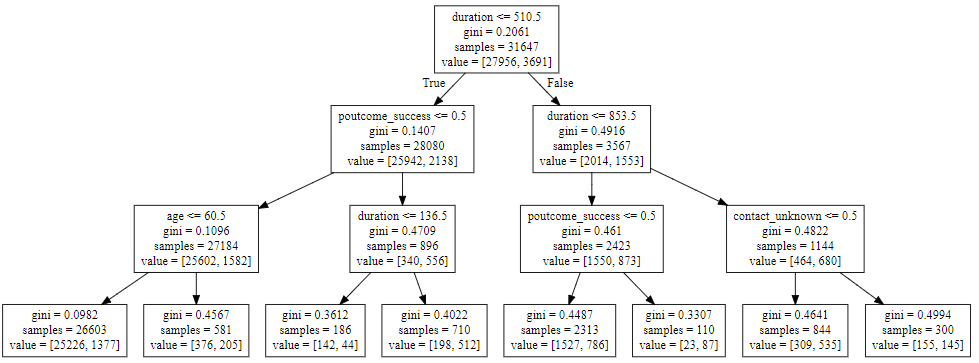

In [63]:
from PIL import Image
img = Image.open('trees_deposit.png')
img

In [64]:
y_pred = tree_fit.predict(X_valid)
print('accuracy_score: ', accuracy_score(y_valid, y_pred))

accuracy_score:  0.897965202005
